# GPAW
The [gpaw](https://gpaw.readthedocs.io/index.html) density-functional theory (DFT) simulation code provides a Python interface supporting the [message passing interface (MPI) for Python - mpi4py](https://mpi4py.readthedocs.io) for parallelization. So `executorlib` is used to orchestrate multiple [gpaw](https://gpaw.readthedocs.io/index.html) simulation each using multiple CPU cores for parallelization. These kind of hierarchical workflows are one of the core strength of `executorlib`. While the same could be achieved by writing the whole simulation workflow using [mpi4py](https://mpi4py.readthedocs.io) this would drastically increase the complexity. With `executorlib` the user can quickly up-scale their simulation workflow without the need to address the parallel execution explicitly, rather the parallelization is introduced on a per-function level, by submitting the functions to the `FluxClusterExecutor` or `FluxJobExecutor`.

In [ ]:
import subprocess
from ase.build import bulk
from atomistics.workflows import (
    analyse_results_for_energy_volume_curve,
    get_tasks_for_energy_volume_curve,
)
import matplotlib.pyplot as plt
import pprint
from tqdm import tqdm
from time import sleep

The only function which is executed using [mpi4py](https://mpi4py.readthedocs.io) is the `evaluate_with_gpaw()` function:

In [2]:
def evaluate_with_gpaw(task_dict, kpts, encut):
    from gpaw import GPAW, PW

    structure = task_dict["calc_energy"].copy()
    structure.calc = GPAW(
        xc="PBE",
        mode=PW(encut),
        kpts=kpts,
    )
    return structure.get_potential_energy()

As a first step of the workflow the equilibrium structure of four Aluminium atoms is strained by 5%.

In [ ]:
task_dict = get_tasks_for_energy_volume_curve(
    structure=bulk("Al", a=4.05, cubic=True),
    num_points=7,
    vol_range=0.05,
    axes=("x", "y", "z"),
)

The resulting dictionary of structures `task_dict` is transformed to simplify the parallel execution:

In [ ]:
task_loop_dict = {k: {"calc_energy": v} for k, v in task_dict["calc_energy"].items()}

The status of the flux cluster is validated using the `flux resource list` command and the `flux jobs -a` command, just to highlight flux was initialized correctly and has access to the available resources.

In [5]:
pprint.pp(subprocess.check_output(["flux", "resource", "list"], universal_newlines=True).split("\n"))

['     STATE NNODES   NCORES    NGPUS NODELIST',
 '      free      1        2        1 '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 ' allocated      0        0        0 ',
 '      down      0        0        0 ',
 '']


In [6]:
pprint.pp(subprocess.check_output(["flux", "jobs", "-a"], universal_newlines=True).split("\n"))

['       JOBID USER     NAME       ST NTASKS NNODES     TIME INFO', '']


## FluxClusterExecutor
The [FluxClusterExecutor](https://executorlib.readthedocs.io/en/latest/2-hpc-cluster.html#flux) is used in this demonstration primarily because flux can be installed on any workstation for testing. The [SlurmClusterExecutor](https://executorlib.readthedocs.io/en/latest/2-hpc-cluster.html#slurm) could be used analogously.

In [7]:
from executorlib import FluxClusterExecutor

The for each strained structure a calculation task is submitted to the `FluxClusterExecutor`. After the successful submission the current status of the flux queue is printed using `flux jobs -a`. Finally, the results are collected by gathering the [concurrent.futures.Future](https://docs.python.org/3/library/concurrent.futures.html#future-objects) objects.

In [ ]:
future_dict = {}
with FluxClusterExecutor() as exe:
    for k, v in task_loop_dict.items():
        future_dict[k] = exe.submit(
            evaluate_with_gpaw, 
            task_dict=v, 
            kpts=(3, 3, 3), 
            encut=300,
            resource_dict={"cores": 2},
        )
    sleep(1)
    pprint.pp(subprocess.check_output(["flux", "jobs", "-a"], universal_newlines=True).split("\n"))
    result_dict = {
        k: f.result() 
        for k, f in tqdm(future_dict.items())
    }
    sleep(1)
    pprint.pp(subprocess.check_output(["flux", "jobs", "-a"], universal_newlines=True).split("\n"))

['       JOBID USER     NAME       ST NTASKS NNODES     TIME INFO',
 '    ƒAXDuVAf jan      executorl+  S      2      -        - ',
 '    ƒAgwGnFh jan      executorl+  S      2      -        - ',
 '    ƒANnfaAs jan      executorl+  R      2      1   0.805s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:38<00:00,  5.45s/it]


['       JOBID USER     NAME       ST NTASKS NNODES     TIME INFO',
 '    ƒBGnAPNF jan      executorl+ CD      2      1   5.577s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒB8hgJKH jan      executorl+ CD      2      1   5.319s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒAzbiDyy jan      executorl+ CD      2      1   5.414s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒAqSxf6X jan      executorl+ CD      2      1   7.899s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒAgwGnFh jan      executorl+ CD      2      1   5.277s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒAXDuVAf jan      executorl+ CD      2      1   5.130s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒANnfaAs jan      executorl+ CD      2      1   5.447s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '']


The resulting energies for the different volumes are fitted using a 3rd order polynomial to derive the bulk modulus as second derivative multiplied by the equilibrium volume.

In [ ]:
fit_dict = analyse_results_for_energy_volume_curve(
    output_dict={"energy": result_dict},
    task_dict=task_dict,
    fit_type="polynomial",
    fit_order=3,
)

The final energy volume curve plot summarizes the results of this calculation.

<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_21313/4024930470.py:2: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Volume [$\AA^3$]")


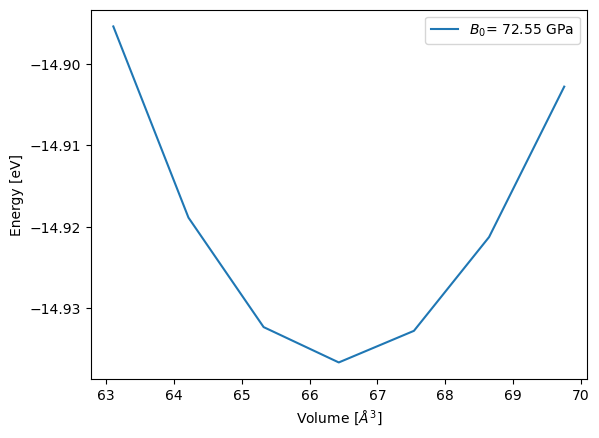

In [10]:
plt.plot(fit_dict["volume"], fit_dict["energy"], label="$B_0$= %0.2f GPa" % fit_dict["bulkmodul_eq"])
plt.xlabel("Volume [$\AA^3$]")
plt.ylabel("Energy [eV]")
plt.legend()

## FluxJobExecutor
In analogy to the [FluxClusterExecutor](https://executorlib.readthedocs.io/en/latest/2-hpc-cluster.html#flux) the [FluxJobExecutor](https://executorlib.readthedocs.io/en/latest/3-hpc-job.html#flux) can be applied to distribute simulation within a given queuing system allocation. The calculation of the bulk modulus with [gpaw](https://gpaw.readthedocs.io) is implemented in the same way.

In [11]:
from executorlib import FluxJobExecutor

The for each strained structure a calculation task is submitted to the `FluxJobExecutor`. After the successful submission the current status of the flux queue is printed using `flux jobs -a`. Finally, the results are collected by gathering the [concurrent.futures.Future](https://docs.python.org/3/library/concurrent.futures.html#future-objects) objects.

In [ ]:
future_dict = {}
with FluxJobExecutor(max_workers=2) as exe:
    for k, v in task_loop_dict.items():
        future_dict[k] = exe.submit(
            evaluate_with_gpaw, 
            task_dict=v, 
            kpts=(3, 3, 3), 
            encut=300,
            resource_dict={"cores": 2},
        )
    sleep(1)
    pprint.pp(subprocess.check_output(["flux", "jobs", "-a"], universal_newlines=True).split("\n"))
    result_dict = {
        k: f.result() 
        for k, f in tqdm(future_dict.items())
    }
    sleep(1)
    pprint.pp(subprocess.check_output(["flux", "jobs", "-a"], universal_newlines=True).split("\n"))

['       JOBID USER     NAME       ST NTASKS NNODES     TIME INFO',
 '    ƒUKWVQxX jan      python      S      2      -        - ',
 '    ƒUKWVQxY jan      python      S      2      -        - ',
 '    ƒUKXyQEs jan      python      S      2      -        - ',
 '    ƒUKXyQEt jan      python      S      2      -        - ',
 '    ƒUKZTPXD jan      python      S      2      -        - ',
 '    ƒUKZTPXE jan      python      S      2      -        - ',
 '    ƒUKV1RgB jan      python      R      2      1   1.030s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒBGnAPNF jan      executorl+ CD      2      1   5.577s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒB8hgJKH jan      executorl+ CD      2      1   5.319s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒAzbiDyy jan      executorl+ CD      2      1   5.414s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒAqSxf6X jan      executorl+ CD      2      1   7.899s '
 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.10s/it]


['       JOBID USER     NAME       ST NTASKS NNODES     TIME INFO',
 '    ƒUKZTPXE jan      python     CD      2      1   3.447s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒUKZTPXD jan      python     CD      2      1   3.978s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒUKXyQEt jan      python     CD      2      1   3.305s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒUKXyQEs jan      python     CD      2      1   3.308s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒUKWVQxY jan      python     CD      2      1   2.872s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒUKWVQxX jan      python     CD      2      1   2.903s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒUKV1RgB jan      python     CD      2      1   3.094s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒBGnAPNF jan      executorl+ CD      2      1   5.577s '
 'p200300e77f488c5f903

The resulting energies for the different volumes are fitted using a 3rd order polynomial to derive the bulk modulus as second derivative multiplied by the equilibrium volume.

In [ ]:
fit_dict = analyse_results_for_energy_volume_curve(
    output_dict={"energy": result_dict},
    task_dict=task_dict,
    fit_type="polynomial",
    fit_order=3,
)

The final energy volume curve plot summarizes the results of this calculation.

<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_21313/4024930470.py:2: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Volume [$\AA^3$]")


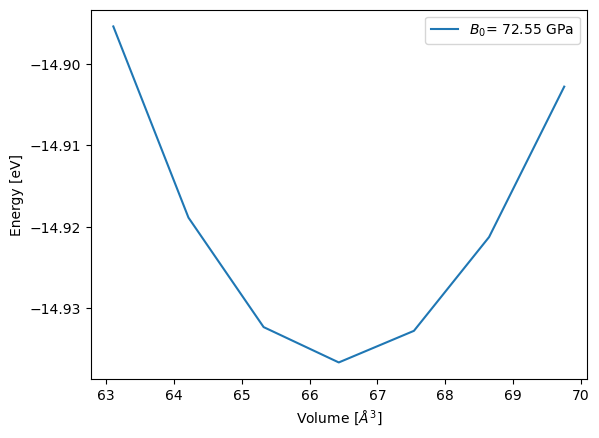

In [14]:
plt.plot(fit_dict["volume"], fit_dict["energy"], label="$B_0$= %0.2f GPa" % fit_dict["bulkmodul_eq"])
plt.xlabel("Volume [$\AA^3$]")
plt.ylabel("Energy [eV]")
plt.legend()